<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-технологического-процесса" data-toc-modified-id="Описание-технологического-процесса-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание технологического процесса</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Построение моделей</a></span></li></ul></div>

# Восстановление золота из руды

Перед нами стоит задача подготовить прототип модели машинного обучения для компании **«Цифра»**, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В работе будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить несколько моделей;
4. Выбрать лучшую модель по метрике sMAPE.

## Описание технологического процесса

![FastPic.Ru](https://i114.fastpic.ru/big/2021/0409/ea/529d1190283d1697f05d87ac910e46ea.jpg)

Технологический процесс получения золота из золотосодержащей руды состоит из трех этапов:
* флотация;
* первый этап очистки;
* второй этап очистки.


**_Флотация_**

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**_Очистка_**

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных

_Параметры технологического процесса:_

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

_Параметры этапов:_

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

Наименование признаков в датафреймах в следующем виде:
[этап].[тип_параметра].[название_параметра]

_Возможные значения для блока [этап]:_

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

_Возможные значения для блока [тип_параметра]:_

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import itertools
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.dummy import DummyRegressor

try:
    gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')
except:
    gold_train = pd.read_csv('home/an4ouce/datasets/gold_recovery_train.csv')
    gold_test = pd.read_csv('home/an4ouce/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('home/an4ouce/datasets/gold_recovery_full.csv')

Данные технологичекого процесса хранятся в трех датасетах: обучающем, тестовом и полном. Взглянем на информацию о каждом из них:

In [2]:
data_list = [gold_train, gold_test, gold_full]
data_list_name = ['gold_train', 'gold_test', 'gold_full']
for data in data_list:
    display(data.head())
    display(data.info())
    display(data.describe())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Видим, что есть пропущенные значения во всех датафреймах, а в **gold_test** пропущено много столбцов. Проверим датафреймы на полные дубликаты:

In [3]:
for data, data_name in zip(data_list, data_list_name):
    print('Количество полных дубликатов в таблице ' + data_name + ':', data.duplicated().sum())

Количество полных дубликатов в таблице gold_train: 0
Количество полных дубликатов в таблице gold_test: 0
Количество полных дубликатов в таблице gold_full: 0


Теперь проверим, не дублируется ли дата/время:

In [4]:
for data, data_name in zip(data_list, data_list_name):
    print('Количество задублированных дат в таблице ' + data_name + ':',
                                         data['date'].duplicated().sum())

Количество задублированных дат в таблице gold_train: 0
Количество задублированных дат в таблице gold_test: 0
Количество задублированных дат в таблице gold_full: 0


Дубликатов нет. Предобработкой данных займемся чуть позже, а пока проверим правильность расчета эффективности обогащения чернового концентрата **rougher.output.recovery**. Он считается по следующей формуле:

![FastPic.Ru](https://i114.fastpic.ru/big/2021/0409/24/a0df51542591f3a52371ba71f5565524.jpg)
    
где:

C — доля золота в концентрате после флотации; <br/>
F — доля золота в сырье до флотации; <br/>
T — доля золота в отвальных хвостах после флотации.

Для подсчета MAE между нашим результатом и значениями в датафрейме временно удалим пропуска в столбцах, используемых в расчете.

In [5]:
gold_train_notnan = gold_train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                              'rougher.output.tail_au', 'rougher.output.recovery'])

gold_train_notnan['rougher_recovery_train'] = ((gold_train_notnan['rougher.output.concentrate_au'] 
                                          * (gold_train_notnan['rougher.input.feed_au'] 
                                        - gold_train_notnan['rougher.output.tail_au'])) 
                                         / (gold_train_notnan['rougher.input.feed_au'] 
                                          * (gold_train_notnan['rougher.output.concentrate_au']
                                        - gold_train_notnan['rougher.output.tail_au']))) * 100

mae_rougher_recovery = mean_absolute_error(gold_train_notnan['rougher.output.recovery'],
                                           gold_train_notnan['rougher_recovery_train'])
print('MAE = ', mae_rougher_recovery)

MAE =  9.444891926100695e-15


MAE получилось очень маленьким, что свидетельствует о том, что значения коэффициента **rougher.output.recovery** в датафрейме посчитаны верно.

Теперь посмотрим, какие столбцы отсутствуют в тестовой выборке:

In [6]:
set(gold_train.columns) - set(gold_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют столбцы с целевым признаком (**rougher.output.recovery, final.output.recovery**), а также все признаки, влияющие на целевые (выходные концентрации веществ после каждого этапа, а также столбцы **calculation** с расчетными характеристиками). Эти признаки тесно связаны с целевыми, и модель не должна их знать заранее, чтобы корректно сделать прогноз.

Теперь займемся предобработкой данных. Удалим строки с пропусками в целевых признаках, а пропуски в признаках заполним методом ffill, так как соседние по времени данные часто похожи.

In [7]:
#сформируем столбцы без даты
col_without_date = gold_full.columns[1:]
col_without_date_train = gold_train.columns[1:]
col_without_date_test = gold_test.columns[1:]

gold_full = gold_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], how='any')
gold_full[col_without_date] = gold_full[col_without_date].ffill(axis=1)
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19439 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19439 non-null float64
final.output.tail_pb                                  19439 non-null float64
final.output.tail_sol                                 19439 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19439 non-null float64
primary_cleaner.input.depressant             

Заполнили **gold_full** методом ffill. Так как в **gold_train** и **gold_test** у нас есть пропуски по времени, то так же поступить мы не можем. Будем заполнять пропуски методом update из **gold_full** по соответствию индексов.
Сначала удалим строки с пропусками в целевых признаках:

In [8]:
gold_train = gold_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], how='any')

Во всех датафреймах установим дату в качестве индекса и дополним **gold_train** данными из **gold_full**.

In [9]:
gold_full.set_index('date', inplace=True)
gold_train.set_index('date', inplace=True)
gold_test.set_index('date', inplace=True)
gold_train.update(gold_full, overwrite=False)
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant                      14149 non-null float64
primary_cleaner.i

В тестовой выборке нет целевых признаков, добавим их из **gold_full**.

In [10]:
gold_test = gold_test.merge(gold_full[['rougher.output.recovery', 'final.output.recovery']],
                                              how='left', left_index=True, right_index=True)

gold_test.update(gold_full, overwrite=False)
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5558 non-null float64
primary_cleaner.input.depressant              5577 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5694 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

И снова удалим пропуски в целевых признаках:

In [11]:
gold_test = gold_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], how='any')
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         529

Проверим, есть ли нулевые значения целевых признаков в обучающей и тестовой выборках. 

In [12]:
gold_test[gold_test['rougher.output.recovery'] == 0]['rougher.output.recovery'].count()

97

In [13]:
gold_test[gold_test['final.output.recovery'] == 0]['final.output.recovery'].count()

40

In [14]:
gold_train[gold_train['rougher.output.recovery'] == 0]['rougher.output.recovery'].count()

297

In [15]:
gold_train[gold_train['final.output.recovery'] == 0]['final.output.recovery'].count()

58

Удалим их, так как нули не являются целью нашего исследования и будут вносить дополнительный шум в модели.

In [16]:
gold_train = gold_train.drop(gold_train[gold_train['rougher.output.recovery'] == 0].index)
gold_train = gold_train.drop(gold_train[gold_train['final.output.recovery'] == 0].index)
gold_test = gold_test.drop(gold_test[gold_test['rougher.output.recovery'] == 0].index)
gold_test = gold_test.drop(gold_test[gold_test['final.output.recovery'] == 0].index)

In [17]:
gold_train.shape

(13795, 86)

In [18]:
gold_test.shape

(5154, 54)

Доля тестовой выборки составляет 27%. Данные подготовлены к анализу, приступим.

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

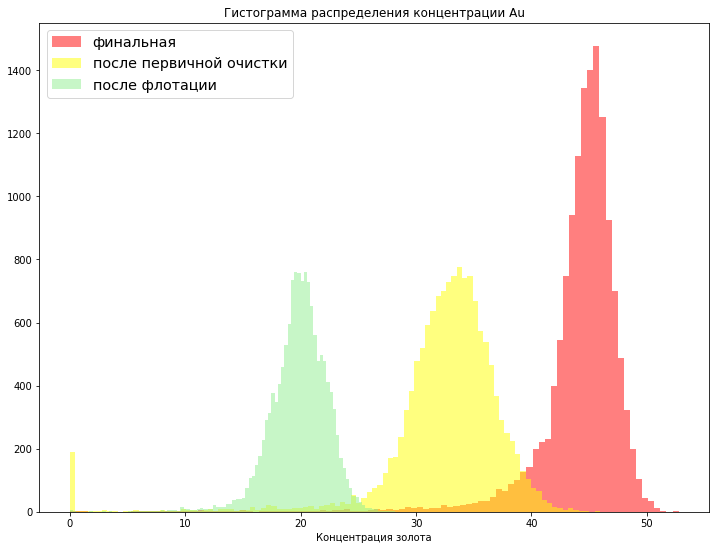

In [19]:
plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_au'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_au'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_au'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация золота')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Au')
plt.show()

Концентрация золота увеличивается с каждым этапом.

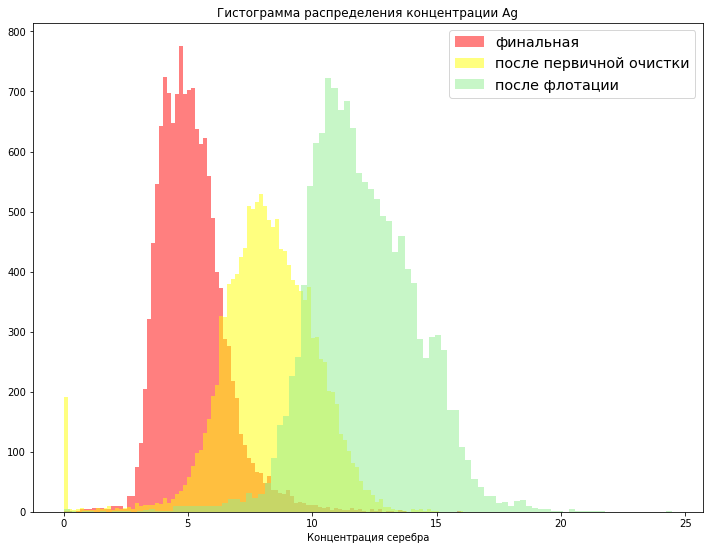

In [20]:
plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_ag'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_ag'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_ag'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация серебра')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Ag')
plt.show()

Концентрация серебра понижается с каждым этапом очистки. Так как целью технологического процесса является получение золота, то менее благородные металлы удаляются.

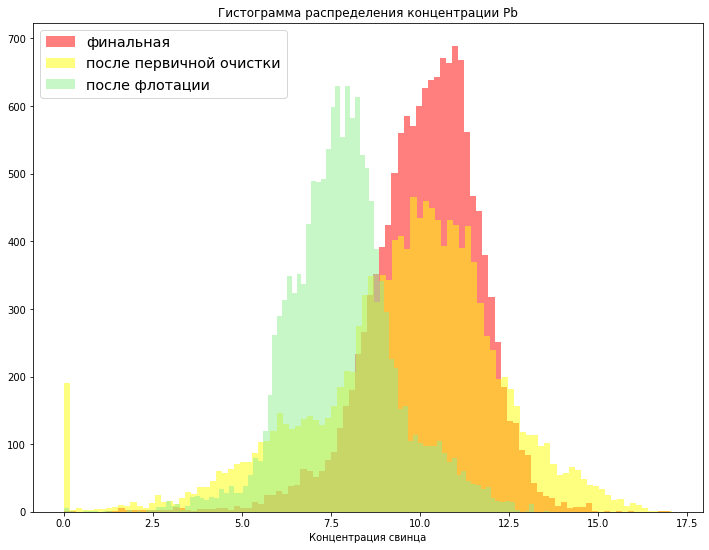

In [21]:
plt.figure(figsize=[12,9])

plt.hist(gold_train['final.output.concentrate_pb'], bins=100, label = 'финальная', alpha=0.5, color='red')
plt.hist(gold_train['primary_cleaner.output.concentrate_pb'], bins=100, label = 'после первичной очистки',
                                                                                alpha=0.5, color='yellow')
plt.hist(gold_train['rougher.output.concentrate_pb'], bins=100, label = 'после флотации', alpha=0.5,
                                                                                       color='lightgreen')

plt.xlabel('Концентрация свинца')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения концентрации Pb')
plt.show()

Концентрация свинца повышается после флотации до первичной очистки. Далее практически не меняется.

Сравним размеры гранул сырья на обучающей и тестовой выборках:

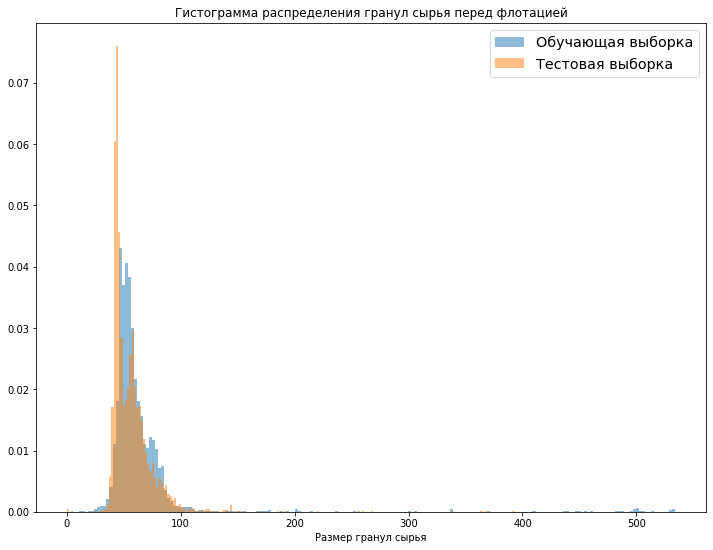

In [22]:
plt.figure(figsize=[12,9])

plt.hist(gold_train['rougher.input.feed_size'], bins=200, density=True, label = 'Обучающая выборка', alpha=0.5)
plt.hist(gold_test['rougher.input.feed_size'], bins=200, density=True, label = 'Тестовая выборка', alpha=0.5)

plt.xlabel('Размер гранул сырья')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения гранул сырья перед флотацией')
plt.show()

Распределения похожи на нормальные со смещением влево. Взглянем на боксплоты:

<Figure size 864x648 with 0 Axes>

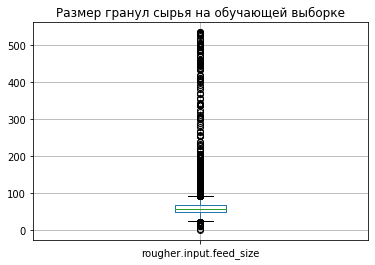

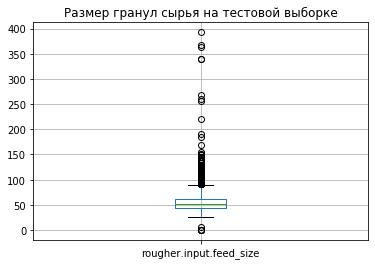

In [23]:
plt.figure(figsize=[12,9])

gold_train.plot(y='rougher.input.feed_size', kind='box', title='Размер гранул сырья на обучающей выборке',
                                                                legend=False, grid=True)
gold_test.plot(y='rougher.input.feed_size', kind='box', title='Размер гранул сырья на тестовой выборке',
                                                                legend=False, grid=True)

plt.show()

У обоих распределений тяжелые "хвосты", но едва ли их можно назвать выбросами. Удалять ничего не будем, так как это реальный технологический процесс, который не всегда подчиняется нормальным законам.
Посмотрим на гистограмму размеров гранул сырья перед первичной очисткой.

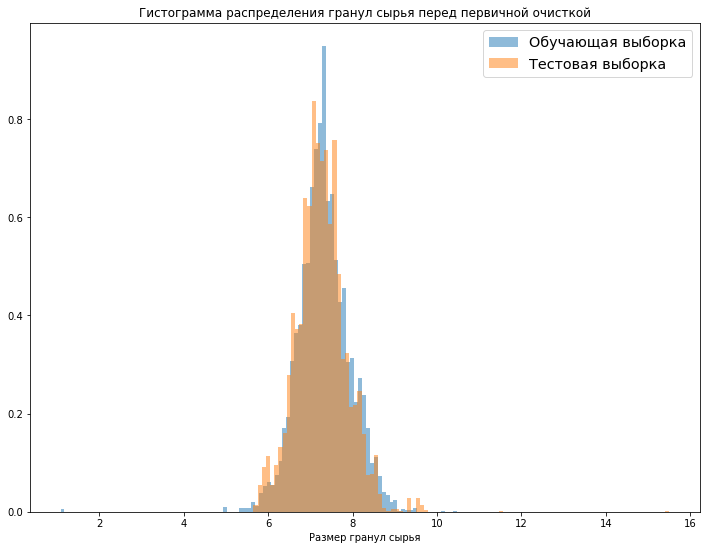

In [24]:
plt.figure(figsize=[12,9])

plt.hist(gold_train['primary_cleaner.input.feed_size'], density=True, bins=100, label = 'Обучающая выборка',
                                                                                                  alpha=0.5)
plt.hist(gold_test['primary_cleaner.input.feed_size'], density=True, bins=100, label = 'Тестовая выборка',
                                                                                                  alpha=0.5)

plt.xlabel('Размер гранул сырья')

plt.legend(loc='upper right', fontsize='x-large')

plt.title('Гистограмма распределения гранул сырья перед первичной очисткой')
plt.show()

<Figure size 864x648 with 0 Axes>

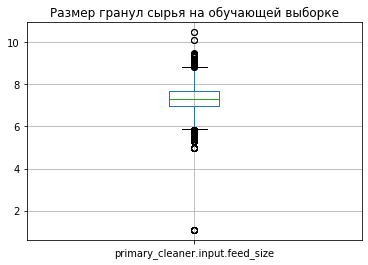

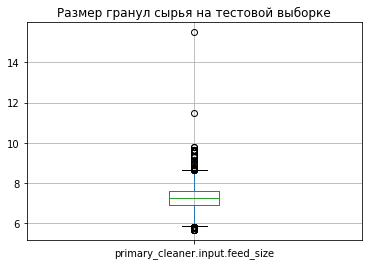

In [25]:
plt.figure(figsize=[12,9])

gold_train.plot(y='primary_cleaner.input.feed_size', kind='box', title='Размер гранул сырья на обучающей выборке',
                                                                legend=False, grid=True)
gold_test.plot(y='primary_cleaner.input.feed_size', kind='box', title='Размер гранул сырья на тестовой выборке',
                                                                legend=False, grid=True)

plt.show()

Распределения гранул сырья перед первичной очисткой похожи на нормальные, значимых отличий нет.

Теперь исследуем суммарную концентрацию всех веществ на разных этапах технологического процесса. Sol брать в расчет не будем, так как скорее всего, это какой-то раствор.

In [26]:
final_output_concentrate_sum_train = (gold_train['final.output.concentrate_au'] + 
                                      gold_train['final.output.concentrate_ag'] + 
                                      gold_train['final.output.concentrate_pb'])

primary_cleaner_output_concentrate_sum_train = (gold_train['primary_cleaner.output.concentrate_au'] + 
                                                gold_train['primary_cleaner.output.concentrate_ag'] + 
                                                gold_train['primary_cleaner.output.concentrate_pb'])

rougher_output_concentrate_sum_train = (gold_train['rougher.output.concentrate_au'] + 
                                        gold_train['rougher.output.concentrate_ag'] + 
                                        gold_train['rougher.output.concentrate_pb'])

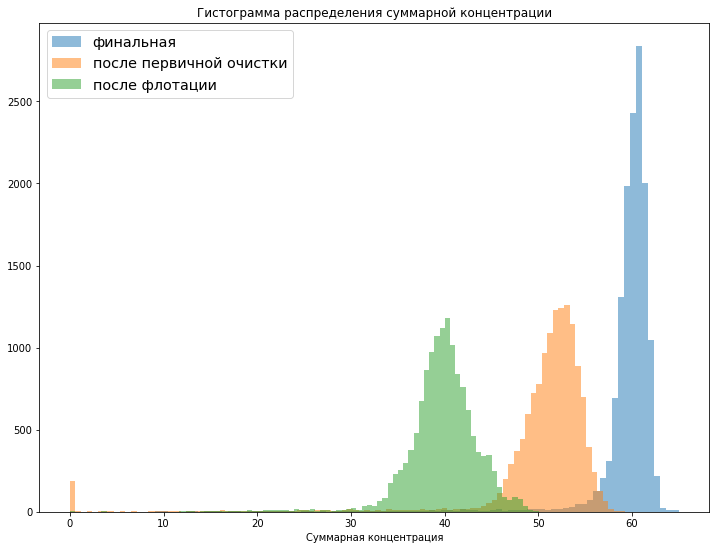

In [27]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'финальная', alpha=0.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'после первичной очистки', alpha=0.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'после флотации', alpha=0.5)

plt.xlabel('Суммарная концентрация')

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения суммарной концентрации')
plt.show()

На гистограмме суммарных концентраций видим нулевые значения после первичной очистки. Посмотрим поближе:

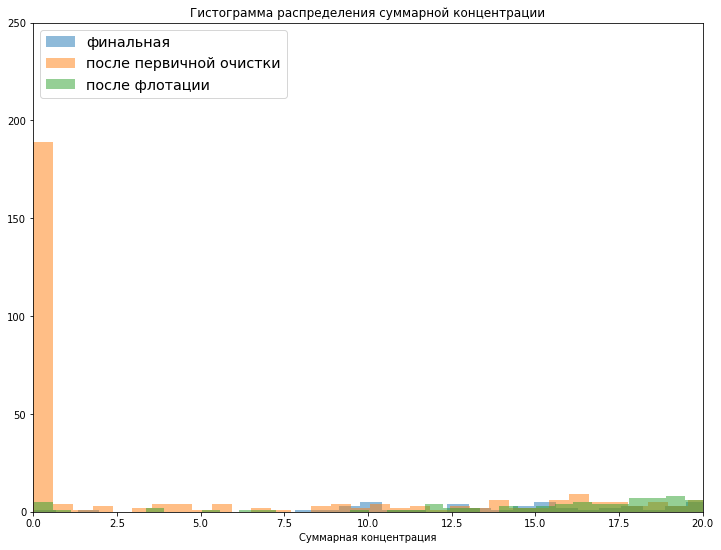

In [28]:
plt.figure(figsize=[12,9])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'финальная', alpha=0.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'после первичной очистки', alpha=0.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'после флотации', alpha=0.5)

plt.xlabel('Суммарная концентрация')
plt.xlim(0, 20)
plt.ylim(0, 250)

plt.legend(loc='upper left', fontsize='x-large')

plt.title('Гистограмма распределения суммарной концентрации')
plt.show()

Вероятно, нулевые значений суммарных концентраций после первичной очистки оказались результатом сбоя технологического процесса и являются аномалиями. Так как целью исследования является золото, удалим нулевые значения **primary_cleaner.output.concentrate_au** из обучающей выборки.

In [29]:
gold_train[gold_train['primary_cleaner.output.concentrate_au'] == 0]['primary_cleaner.output.concentrate_au'].count()

70

In [30]:
gold_train = gold_train.drop(gold_train[gold_train['primary_cleaner.output.concentrate_au'] == 0].index)
gold_train.shape

(13725, 86)

**Вывод:** в данном разделе была проанализирована концентрация веществ на разных этапах технологического процесса, найдены и удалены аномалии. Пора приступать к построению моделей.

## Построение моделей

Нам необходимо спрогнозировать две цели - **rougher.output.recovery** и **final.output.recovery**. Для начала удалим из обучающей выборки столбцы, которых нет в тестовой выборке.

In [31]:
col_to_delete = set(gold_train.columns)-set(gold_test.columns)
col_to_delete

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

In [32]:
gold_train = gold_train.drop(col_to_delete, axis=1)
gold_train.shape

(13725, 54)

In [33]:
gold_test.shape

(5154, 54)

In [34]:
gold_train.columns

Index(['final.output.recovery', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_a_air', 

Создадим датафрейм **rougher_all** с признаками, которые относятся к этапу флотации:

In [35]:
rougher_all = gold_train.loc[:, 'rougher.input.feed_ag':'rougher.state.floatbank10_f_level']
rougher_all.columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level'],
      dtype='object')

Выделим признаки **features_rougher** и **target_rougher** из rougher_all:

In [36]:
features_rougher = rougher_all.drop(['rougher.output.recovery'], axis=1)
target_rougher = rougher_all['rougher.output.recovery']
features_rougher.shape

(13725, 22)

Выделим признаки **features_final** и **target_final** из обучающей выборки:

In [37]:
features_final = gold_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_final = gold_train['final.output.recovery']
features_final.shape

(13725, 52)

Теперь выделим аналогичные признаки из тестовой выборки.

In [38]:
features_rougher_test = gold_test.loc[:, 'rougher.input.feed_ag':'rougher.state.floatbank10_f_level']
target_rougher_test = gold_test['rougher.output.recovery']
features_rougher_test.shape

(5154, 22)

In [39]:
features_final_test = gold_test.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_final_test = gold_test['final.output.recovery']
features_final_test.shape

(5154, 52)

Будем оценивать модели по метрике качества **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика **sMAPE** вычисляется так:

![FastPic.Ru](https://i114.fastpic.ru/big/2021/0409/a8/93d223fc342976d485942423472d50a8.jpg)

где:

yi - действительное значение целевого признака;

^yi - предсказанное значение целевого признака;

n - количество значений признака.

Напишем функцию для вычисления **sMAPE**:

In [40]:
def smape_score(target, prediction):
    smape = (100/len(target)) * np.sum(2* np.abs(prediction - target) / (np.abs(target) + np.abs(prediction)))
    return smape

Так как у нас два целевых признака, итоговое **sMAPE** будет считаться по формуле:

![FastPic.Ru](https://i114.fastpic.ru/big/2021/0409/86/0bb770828d464961f5508bcb3c781c86.jpg)

Напишем функцию для вычисления итогового **sMAPE**:

In [41]:
def smape_total(rougher, final):
    smape = 0.25*rougher + 0.75*final
    return smape

Будем обучать следующие модели: линейная регрессия, случайный лес и метод к-ближайших соседей.
Создадим свой оценщик с помощью make_scorer:

In [42]:
my_scorer = make_scorer(smape_score, greater_is_better=False)

Подберем оптимальные параметры для линейной регрессии с помощью RandomizedSearchCV, в нем уже есть кросс-валидация.

In [43]:
model_linear = LinearRegression()

fit_intercept = [True, False]
normalize = [True, False]
hyperparameters = dict(fit_intercept=fit_intercept, normalize=normalize)

rs_linear = RandomizedSearchCV(model_linear, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        random_state=0,
                        scoring=my_scorer)
rs_linear.fit(features_rougher, target_rougher)
smape_rougher_linear = rs_linear.best_score_
print('Параметры Linear Regression: ', rs_linear.best_params_)

Параметры Linear Regression:  {'normalize': False, 'fit_intercept': True}


Теперь проверим кросс-валидацией качество модели с подобранными гиперпараметрами на финальных признаках:

In [44]:
smape_final_linear = cross_val_score(rs_linear, features_final, target_final, scoring=my_scorer)

Посчитаем итоговое **sMAPE** для линейной регрессии:

In [45]:
smape_tot = smape_total(smape_rougher_linear, np.mean(smape_final_linear))
print('sMAPE для линейной регрессии: ', smape_tot.round(2))

sMAPE для линейной регрессии:  -12.0


Теперь обучим модель случайного леса и проверим качество кросс-валидацией:

In [46]:
model_forest = RandomForestRegressor()

cv_score_rougher = cross_val_score(model_forest, features_rougher, target_rougher, scoring=my_scorer)
cv_score_final = cross_val_score(model_forest, features_final, target_final, scoring=my_scorer)
smape_tot = smape_total(np.mean(cv_score_rougher), np.mean(cv_score_final))
print('sMAPE для случайного леса: ', smape_tot.round(2))

sMAPE для случайного леса:  -11.02


Подберем гиперпараметры для KNeighborsRegressor:

In [47]:
KNeighborsRegressor().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [48]:
model_knn = KNeighborsRegressor()
                                     
n_neighbors = [int(x) for x in np.linspace(start = 5, stop = 30, num = 15)]
leaf_size = [int(x) for x in np.linspace(start = 30, stop = 100, num = 10)]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute']
p = [1,2]

hyperparameters = {'n_neighbors': n_neighbors,
               'leaf_size': leaf_size,
               'weights': weights,
               'algorithm': algorithm,
               'p': p}

rs_knn = RandomizedSearchCV(model_knn, 
                        hyperparameters, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=1,
                        random_state=0,
                        scoring=my_scorer)
rs_knn.fit(features_rougher, target_rougher)
smape_rougher_knn = rs_knn.best_score_
print('Параметры KNearestNeighbors: ', rs_knn.best_params_)

Параметры KNearestNeighbors:  {'weights': 'uniform', 'p': 1, 'n_neighbors': 30, 'leaf_size': 92, 'algorithm': 'kd_tree'}


Проверим качество кросс-валидацией на финальных признаках:

In [49]:
model_knn = KNeighborsRegressor(weights='uniform', p=1, n_neighbors=30, leaf_size=92, algorithm='kd_tree')
smape_final_knn = cross_val_score(model_knn, features_final, target_final, scoring=my_scorer)

Посчитаем итоговое **sMAPE** для KNearestNeighbors:

In [50]:
smape_tot = smape_total(smape_rougher_knn, np.mean(smape_final_knn))
print('sMAPE для KNearestNeighbors: ', smape_tot.round(2))

sMAPE для KNearestNeighbors:  -12.33


Пока лучшим выглядит KNearestNeighbors с наименьшим значением **sMAPE**. Проверим модель на тестовой выборке:

In [51]:
model_knn.fit(features_rougher, target_rougher)
predictions_rougher_test = model_knn.predict(features_rougher_test)
smape_rougher_test = smape_score(target_rougher_test, predictions_rougher_test)

model_knn.fit(features_final, target_final)
predictions_final_test = model_knn.predict(features_final_test)
smape_final_test = smape_score(target_final_test, predictions_final_test)

score_knn = smape_total(smape_rougher_test, smape_final_test)
print('sMAPE для К-ближайших соседей на тестовой выборке: ', score_knn.round(2))

sMAPE для К-ближайших соседей на тестовой выборке:  8.87


Сложно понять результат без проверки модели на адекватность. Создадим дамми-модель и сравним ее предсказания с нашей моделью:

In [52]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_rougher, target_rougher)
predictions_rougher_test = dummy.predict(features_rougher_test)
smape_rougher_test = smape_score(target_rougher_test, predictions_rougher_test)

dummy.fit(features_final, target_final)
predictions_final_test = dummy.predict(features_final_test)
smape_final_test = smape_score(target_final_test, predictions_final_test)

score_dummy = smape_total(smape_rougher_test, smape_final_test)
print('sMAPE для дамми-модели на тестовой выборке: ', score_dummy.round(2))

sMAPE для дамми-модели на тестовой выборке:  7.37


Результат не очень. Дамми-модель предсказывает лучше. Возможно, так произошло оттого, что наша модель переучилась, запуталась в признаках. Проверим модель линейной регрессии, она, как правило, самая предсказуемая.

In [53]:
rs_linear.fit(features_rougher, target_rougher)
predictions_rougher_test = rs_linear.predict(features_rougher_test)
smape_rougher_test = smape_score(target_rougher_test, predictions_rougher_test)

rs_linear.fit(features_final, target_final)
predictions_final_test = rs_linear.predict(features_final_test)
smape_final_test = smape_score(target_final_test, predictions_final_test)

score_linear = smape_total(smape_rougher_test, smape_final_test)
print('sMAPE для линейной регрессии на тестовой выборке: ', score_linear.round(2))

sMAPE для линейной регрессии на тестовой выборке:  7.12


Результат для линейной регрессии получился лучше, чем у дамми-модели, что свидетельствует об адекватности выбранной нами модели линейной регрессии.

**Вывод:** в данной работе был рассмотрен технологический процесс добычи золота из золотой руды. Необходимо было построить модель, прогнозирующую эффективность обогащения чернового концентрата (*rougher.output.recovery*) и финального концентрата (*final.output.recovery*). Была проведена преодобработка данных, найдены и удалены аномалии, построены регрессионные модели. В результате лучшей моделью является линейная регрессия с итоговым sMAPE = 7.12.